In [7]:
import sys
sys.path.append('../src')
import argparse
import torch
from SAE_models import get_cfg, TopKSAE, VanillaSAE, JumpReLUSAE, BatchTopKSAE
from SAE_training import SAETraining
from torch.utils.data import DataLoader
import numpy as np
import json
import lightning.pytorch as L

from hdf_dataset import HDF3DIterator

In [8]:
shared_data_path = '/grid/hackathon/data_norepl/splarseers/output/'
dataset_name = 'embed_test'
test_ds = HDF3DIterator(shared_data_path+dataset_name+'.h5', dataset_name, preload=False)
subset = torch.utils.data.Subset(test_ds, range(200))
test_dl = torch.utils.data.dataloader.DataLoader(subset, batch_size=100, num_workers=0)

cfg = {'seed': 49, 'batch_size': 2097152, 'lr': 0.0003, 'l1_coeff': 0, 'beta1': 0.9, 'beta2': 0.99, 'max_grad_norm': 100000, 'dtype': torch.float32, 'act_size': 32, 'dict_size': 1024, 'wandb_project': 'sparse_autoencoders', 'input_unit_norm': False, 'perf_log_freq': 1000, 'sae_type': 'topk', 'checkpoint_freq': 10000, 'n_batches_to_dead': 5, 'warmstart_batches': 0, 'warmstart_start_factor': 0.0001, 'warmstart_end_factor': 1, 'scheduler': 'RedOnPlateau', 'weight_decay': 0.0001, 'reduceLROnPlateau_factor': 0.1, 'reduceLROnPlateau_patience': 4, 'reduceLROnPlateau_threshold': 0.0001, 'reduceLROnPlateau_cooldown': 0, 'reduceLROnPlateau_min': 0, 'reduceLROnPlateau_eps': 1e-08, 'epochs': 1000, 'training_set_batches': 1000, 'outpath': './out/', 'min_delta': 0, 'patience': 10, 'accelerator': 'auto', 'devices': 'auto', 'include_checkpointing': True, 'include_early_stopping': True, 'track_LR': True, 'top_k': 16, 'top_k_aux': 256, 'aux_penalty': 0.0625, 'bandwidth': 0.001, 'num_workers': 16, 'train_data_path': '/grid/hackathon/data_norepl/splarseers/output/embed_train.h5', 'val_data_path': '/grid/hackathon/data_norepl/splarseers/output/embed_val.h5', 'test_data_path': '/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'preload_data': True, 'train_dataset_name': 'embed_train', 'val_dataset_name': 'embed_val', 'test_dataset_name': 'embed_test', 'hook_point': 'Add_14_MB_3_out', 'model_name': 'SpliceAI_WG', 'name': 'SpliceAI_WG_Add_14_MB_3_out_1024_topk_16_0.0003'}


model = TopKSAE.load_from_checkpoint('../out/SpliceAI_WG_Add_14_MB_3_out_1024_topk_16_0.0003_49_epoch=04_val_loss=5.75.ckpt', cfg=cfg)

trainer = L.Trainer(max_epochs=2)

preds = trainer.predict(model, test_dl)








/grid/kinney/home/desmara/.conda/envs/architecture_search_env/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/kinney/home/desmara/.conda/envs/architecture_search_env/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /grid/kinney/home/desmara/.conda/envs/architecture_s ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/grid/kinney/home/desmara/.conda/envs/architecture_search_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in 

Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
reconstructions, activations = zip(*preds)
reconstructions = torch.cat(reconstructions)
activations = torch.cat(activations)
print(reconstructions.shape)
print(activations.shape)




torch.Size([200, 32])
torch.Size([200, 1024])


In [16]:
sort_idx = torch.argsort((activations>0).sum(dim=0))
sorted_activations = activations[:,sort_idx]
(sorted_activations>0).sum(dim=0)

tensor([  0,   0,   0,  ..., 135, 147, 200])

In [19]:
(sorted_activations>0).sum(dim=0).squeeze()

tensor([  0,   0,   0,  ..., 135, 147, 200])

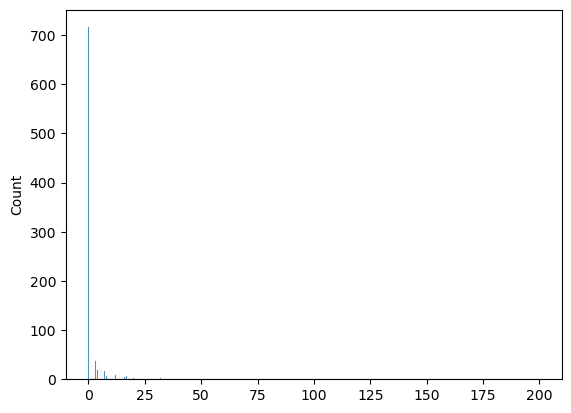

In [20]:
import seaborn as sns
sns.histplot((sorted_activations>0).sum(dim=0).squeeze())
plt.show()


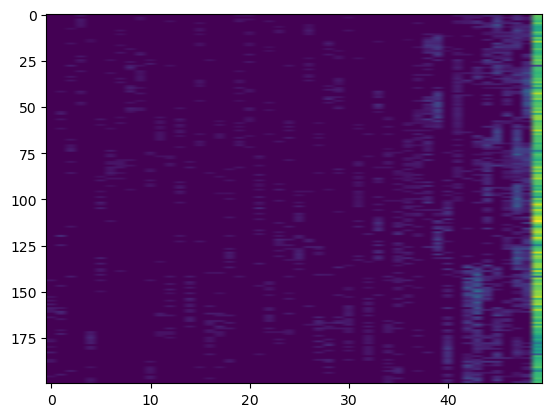

In [24]:
import matplotlib.pyplot as plt

plt.imshow(activations[:,sort_idx][:,-50:], aspect='auto')
plt.show()






In [25]:
!ls -lh ../out/SpliceAI_WG*


-rw------- 1 desmara kinney lab staff 784K Mar 13 22:44 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_16_0.0003_49_epoch=07_val_loss=4.25.ckpt'
-rw------- 1 desmara kinney lab staff 784K Mar 13 22:39 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_8_0.0003_49_epoch=07_val_loss=16.92.ckpt'
-rw------- 1 desmara kinney lab staff 784K Mar 14 10:38 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_8_0.0003_49_epoch=08_val_loss=16.83.ckpt'
-rw------- 1 desmara kinney lab staff 806K Mar 13 22:45 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=11_val_loss=0.09.ckpt'
-rw------- 1 desmara kinney lab staff 806K Mar 13 22:46 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=12_val_loss=0.85.ckpt'
-rw------- 1 desmara kinney lab staff 806K Mar 14 10:33 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=13_val_loss=12.23.ckpt'
-rw------- 1 desmara kinney lab staff 806K Mar 13 23:53 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu

In [28]:
grabs = !ls -lh ../out/SpliceAI_WG* | grep "Mar 13"
grabs

['-rw------- 1 desmara kinney lab staff 784K Mar 13 22:44 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_16_0.0003_49_epoch=07_val_loss=4.25.ckpt',
 '-rw------- 1 desmara kinney lab staff 784K Mar 13 22:39 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_8_0.0003_49_epoch=07_val_loss=16.92.ckpt',
 '-rw------- 1 desmara kinney lab staff 806K Mar 13 22:45 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=11_val_loss=0.09.ckpt',
 '-rw------- 1 desmara kinney lab staff 806K Mar 13 22:46 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=12_val_loss=0.85.ckpt',
 '-rw------- 1 desmara kinney lab staff 806K Mar 13 23:53 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=13_val_loss=3.01.ckpt',
 '-rw------- 1 desmara kinney lab staff 784K Mar 13 21:57 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_topk_16_0.0003_49_epoch=07_val_loss=5.59.ckpt',
 '-rw------- 1 desmara kinney lab staff 784K Mar 13 21:56 ../out/SpliceAI_WG_Add_14_MB_3_out_1024_to

In [29]:
finished_ckpts  = [grab.split(' ')[-1] for grab in grabs]
finished_ckpts






['../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_16_0.0003_49_epoch=07_val_loss=4.25.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_batch_topk_8_0.0003_49_epoch=07_val_loss=16.92.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=11_val_loss=0.09.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=12_val_loss=0.85.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_jumprelu_16_0.0003_49_epoch=13_val_loss=3.01.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_topk_16_0.0003_49_epoch=07_val_loss=5.59.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_topk_8_0.0003_49_epoch=07_val_loss=15.35.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_vanilla_16_0.0003_49_epoch=11_val_loss=0.28.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_vanilla_16_0.0003_49_epoch=12_val_loss=2.58.ckpt',
 '../out/SpliceAI_WG_Add_14_MB_3_out_1024_vanilla_16_0.0003_49_epoch=13_val_loss=21.67.ckpt']

In [41]:
!grep "{" ../logs/WG_SpliceAI_vanilla_l1_0.5_SAE_training_job.sh_qsub.sh.stout.50126.1 


{'seed': 49, 'batch_size': 2097152, 'lr': 0.0003, 'l1_coeff': 0.5, 'beta1': 0.9, 'beta2': 0.99, 'max_grad_norm': 100000, 'dtype': torch.float32, 'act_size': 32, 'dict_size': 1024, 'wandb_project': 'sparse_autoencoders', 'input_unit_norm': False, 'perf_log_freq': 1000, 'sae_type': 'vanilla', 'checkpoint_freq': 10000, 'n_batches_to_dead': 5, 'warmstart_batches': 0, 'warmstart_start_factor': 0.0001, 'warmstart_end_factor': 1, 'scheduler': 'RedOnPlateau', 'weight_decay': 0.0001, 'reduceLROnPlateau_factor': 0.1, 'reduceLROnPlateau_patience': 4, 'reduceLROnPlateau_threshold': 0.0001, 'reduceLROnPlateau_cooldown': 0, 'reduceLROnPlateau_min': 0, 'reduceLROnPlateau_eps': 1e-08, 'epochs': 1000, 'training_set_batches': 1000, 'outpath': './out/', 'min_delta': 0, 'patience': 10, 'accelerator': 'auto', 'devices': 'auto', 'include_checkpointing': True, 'include_early_stopping': True, 'track_LR': True, 'top_k': 16, 'top_k_aux': 256, 'aux_penalty': 0.0625, 'bandwidth': 0.001, 'num_workers': 16, 'train_

In [45]:
cfgs = !grep "{" ../logs/WG_SpliceAI_*.sh.stout.*
cfgs


["../logs/WG_SpliceAI_batchtopk_K16_longer_SAE_training_job.sh_qsub.sh.stout.50132.1:{'seed': 49, 'batch_size': 2097152, 'lr': 0.0003, 'l1_coeff': 0, 'beta1': 0.9, 'beta2': 0.99, 'max_grad_norm': 100000, 'dtype': torch.float32, 'act_size': 32, 'dict_size': 1024, 'wandb_project': 'sparse_autoencoders', 'input_unit_norm': False, 'perf_log_freq': 1000, 'sae_type': 'batch_topk', 'checkpoint_freq': 10000, 'n_batches_to_dead': 5, 'warmstart_batches': 0, 'warmstart_start_factor': 0.0001, 'warmstart_end_factor': 1, 'scheduler': 'RedOnPlateau', 'weight_decay': 0.0001, 'reduceLROnPlateau_factor': 0.1, 'reduceLROnPlateau_patience': 4, 'reduceLROnPlateau_threshold': 0.0001, 'reduceLROnPlateau_cooldown': 0, 'reduceLROnPlateau_min': 0, 'reduceLROnPlateau_eps': 1e-08, 'epochs': 1000, 'training_set_batches': 1000, 'outpath': './out/', 'min_delta': 0, 'patience': 10, 'accelerator': 'auto', 'devices': 'auto', 'include_checkpointing': True, 'include_early_stopping': True, 'track_LR': True, 'top_k': 16, '